[LAPTOP-TL1238BG:01682] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.LAPTOP-TL1238BG.1000/jf.0/2873753600/shared_mem_cuda_pool.LAPTOP-TL1238BG could be created.
[LAPTOP-TL1238BG:01682] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


2025-06-11 18:30:21,694 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


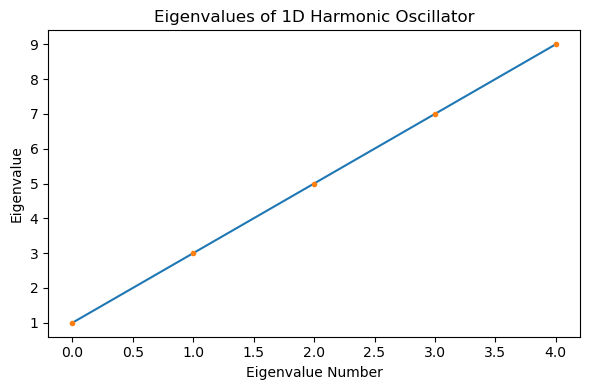

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

'''
Code solving the 1D Harmonic Oscillation Equation:
        
        -d²ψ/dx² + x²ψ = λψ

Choosing boundaries as x ∈ [-5, 5], to find the eigenvalue λ. Then plotting it against an expected
equation of λ:

        λ = 2n + 1

To see if the analytical solutions fit the theoretical equation
'''
#Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 64, bounds=(-5,5), dealias=3/2)

#Fields
phi = dist.Field(name='phi', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')
lam = dist.Field(name='lam')

#Substitutions
x = dist.local_grid(xbasis)
x2 = dist.Field(xbasis)
x2['g'] = x**2
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
phix = dx(phi) + lift(tau1)
phixx = dx(phix) + lift(tau2)

#Problem
problem = d3.EVP([phi, tau1, tau2], eigenvalue=lam, namespace=locals())
problem.add_equation("- phixx + x2*phi - lam*phi = 0")
problem.add_equation("phi(x = -5) = 0")
problem.add_equation("phi(x = 5) = 0")

#Solver
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues.real)
n = np.arange(evals.size)
true_evals = 2*n + 1

#Plot
plt.figure(figsize=(6,4))
plt.plot(n[0:5], true_evals[0:5])
plt.plot(n[0:5], evals[0:5], '.')
plt.xlabel('Eigenvalue Number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of 1D Harmonic Oscillator')
plt.tight_layout()
plt.savefig("1d_harmonic_oscillator.png", dpi=200)